# R-CNN

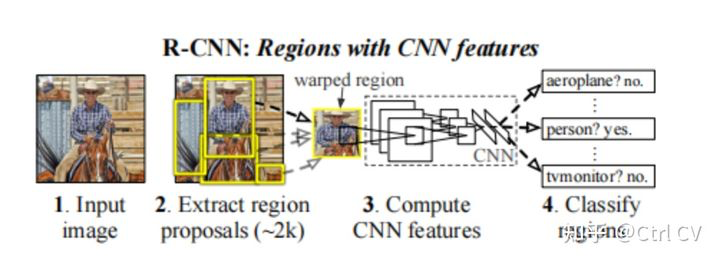

现在，将目光穿越回2012年，hinton刚刚提出alexnet的时代。

此时，该如何审视目标检测任务？

当时的目标检测采用的是滑动窗口+手动特征+分类器的思路。

该方法的弱点包括

* 速度慢

* 精度差

精度差的问题是由手工特征造成的，因此可以通过CNN解决

速度慢的问题是由滑动窗口造成的，结合图像金字塔，速度会非常的慢。

如何解决速度慢的问题？

## 区域选择算法

如果采用金字塔+滑动窗口，同时加上不同窗口比例，目标框可能会数百万计。

对每个目标框的区域都进行图像分类，会造成极大的计算压力。

然而，绝大部分的框都是背景，只有少部分的框是目标。

一种直观的解决思路就是，**从图像中筛选出可能存在目标的区域，然后再对这些目标进行仔细辨认**

这种思路也是符合人类视觉习惯，例如，人们首先会定位出人的位置，再辨识出是谁。

2014年提出的RCNN就是用到这种思路。

### 如何筛选出可能存在目标的区域？

从视觉上讲，我们要先找出物体，再判断物体类别。

那么什么是一个物体？就是表达同一个语义的像素区域。

例如，一个雪原场景中，一些黑色的色块，就是同一个物体。

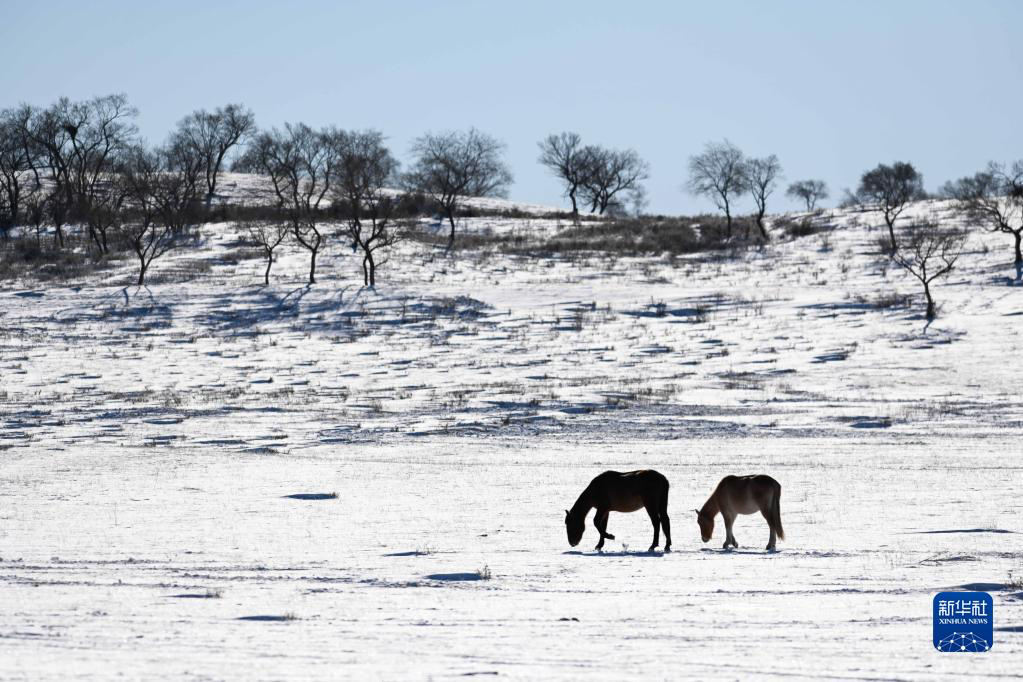

这里就涉及到一个基本假设：**表达同一个语义信息的像素，在数值上存在连续性或者相关性**

在RCNN中，采用了一种基于传统方法的图像分割算法（Felzenszwalb and Huttenlocher algorithm），按照像素值将图像分割成小的子块，再进行合并后得到的图像分割结果。

关于图像分割算法的[样例代码](https://www.osgeo.cn/scikit-image/auto_examples/segmentation/plot_segmentations.html)如下所示，具体原理细节在图像分割部分讲授。

Felzenszwalb number of segments: 194


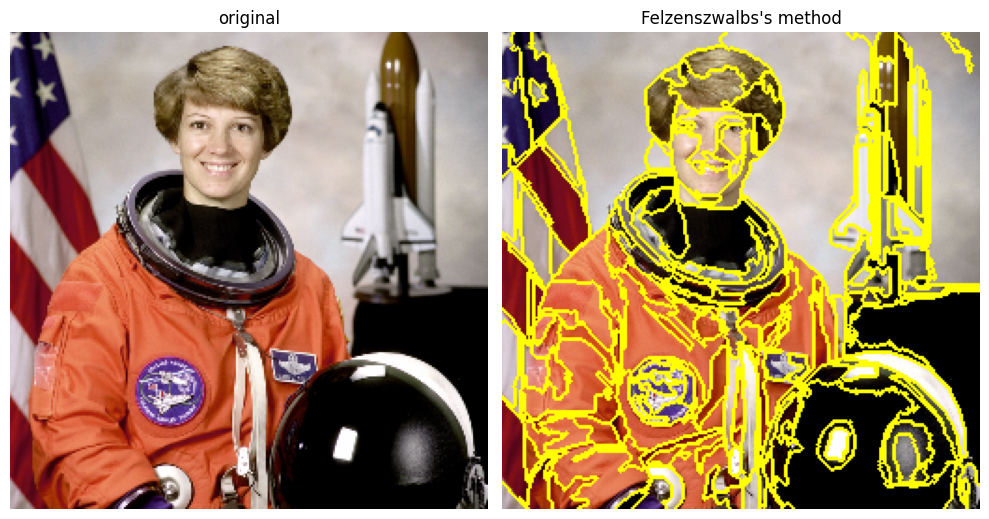

In [11]:
# Felzenszwalb and Huttenlocher
import matplotlib.pyplot as plt
import numpy as np

from skimage.data import astronaut
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

img = img_as_float(astronaut()[::2, ::2])

segments_fz = felzenszwalb(img, scale=100, sigma=0.5, min_size=50)

print(f"Felzenszwalb number of segments: {len(np.unique(segments_fz))}")

fig, ax = plt.subplots(1, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0].imshow(img)
ax[0].set_title("original")
ax[1].imshow(mark_boundaries(img, segments_fz))
ax[1].set_title("Felzenszwalbs's method")

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

再回顾一下我们的目标，希望生成多个包含物体的候选框。

那么如何通过分割结果得到候选框？

具体步骤如下：

1. 计算所有邻域之间的相似性（像素相似性、纹理相似性、大小相似性和形状相似性）
2. 两个最相似的区域被组合到一起
3. 计算合并区域和相邻区域的相似度
4. 重复2、3，直到整个图像变为一个区域

算法截图：
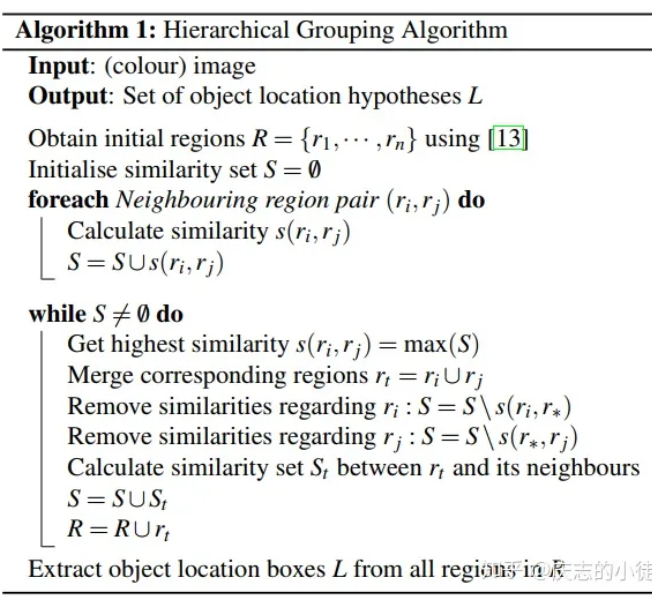

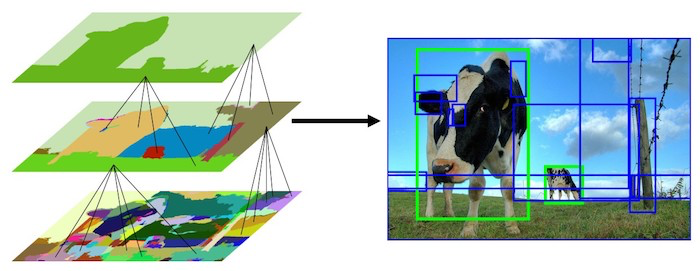

具体解释：

1. 先计算各个区域间的相关性
2. 找出相关性最大对应的两个区域，进行合并。
3. 合并后，将合并的区域加入集合R，并将原先两个区域的相关性删除，加入新区域的相关性
4. 重复上述步骤2和3，直到全部的相关性从S中删除。
5. 最后根据4得到的全部区域集合，得到对应区域的全部候选框。



以上步骤被称为selective search。

### 计算相似度

计算相似度有四种方法：

* 颜色
* 纹理
* 大小
* 形状

**颜色相似度**

如何度量颜色？  直方图

对每个通道量化成25个直方图，三个通道就有75维直方图

根据直方图的重叠区域来定义颜色的相似度

$$s_c(r_i, r_j)=\sum_{k=1}^{75} \min(r_i^{(k)}, r_j^{(k)})$$

**纹理相似度**

定义纹理也采用直方图的方式进行。

纹理直方图如何定义？统计每个像素的特征方向。

定义出这些直方图之后，通过直方图的重叠区域定义纹理相似度。

$$s_t(r_i, r_j)=\sum_{k=1}^{N} \min(r_i^{(k)}, r_j^{(k)})$$

**大小相似度**

大小相似度并不是对同样大小的区域合并，而是希望优先合并小的区域。

$$s_s(r_i, r_j)=1-\frac{size(r_i)+size(r_j)}{size(img)}$$

**形状相似度**

形状相似度也不是为了将相同形状的区域合并，而是衡量两个区域是否更加吻合。(像拼图一样，如果合并后的区域更加符合矩形框，则优先级更高)

$$s_f(r_i, r_j)=1-\frac{size(\text{BoundingBox} - size(r_i) - size(r_j))}{size(im)}$$



综上所述，总体相似度为

$$s(r_i, r_j) = \lambda_cs_c + \lambda_ts_t + \lambda_ss_s + \lambda_fs_f$$

最终，selective search算法生成了大量的候选框，从上至下挑选一千至两千个框，称为region proposal.

相比于传统的框来说，region proposal的方式效率极高，避免对每个像素进行遍历。

**小结**：selective search的步骤为

1. 用分割算法获取若干个区域

2. 计算两两区域之间的相似度，原则：给小的区域与吻合的区域赋予较大的相似度

3. 挑选出相似度最大的区域，进行合并；

4. 合并后的区域送入备选区域集合，并删除掉合并前的相似度

5. 利用步骤2计算出新区域与邻居区域的相似度，加入相似度集合

6. 重复3、4、5步骤，直到相似度集合中没有可以合并的值。

从候选区域集合中获取1-2千个区域，用于后续检测。


## 特征提取与分类

区域选择代替了滑动窗口，下一步就需要对候选区域进行特征提取。

考虑到选择的区域存在不同的尺度和比例，此处第一步就需要对齐所有区域。

**step1. resize region**： 将所有的区域resize成同样大小的尺寸

**step2. extract feature with CNN**：将所有的区域送入CNN中提取特征。

还记得什么是CNN提取的特征吗？

把softmax去掉后的feature map就是特征。

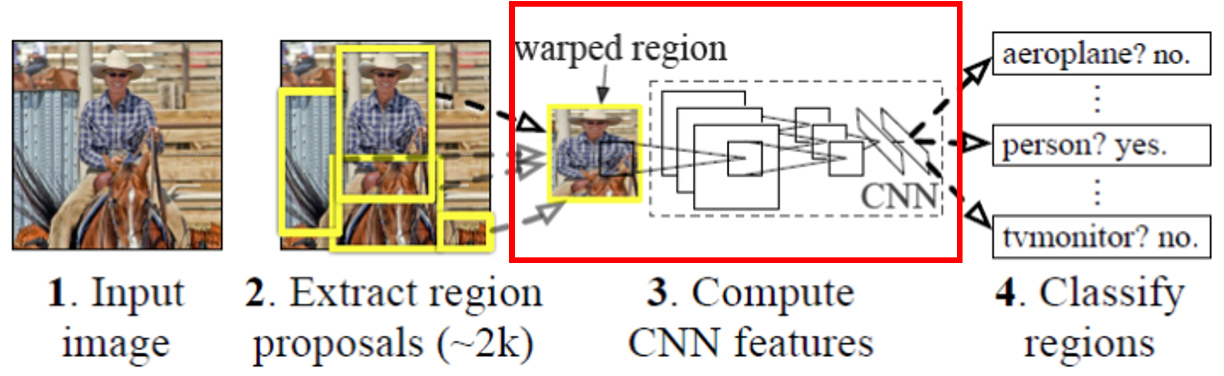

采用的模型为alexnet或者vgg16

**那么如何训练这个CNN？**

- step1. 用imagenet训练分类网络

- step2. 针对检测目标进行训练。

    * 数据集采用pascal voc，每张图像用selective search得到候选框，用候选框作为CNN的输入
    * 定义标签：当候选框与目标检测框的重叠度超过0.5，则认为是一个正样本；否则是一个负样本
    * 此处为多分类器分类，每个分类器是一个二分类，判断是不是这个目标
   





## 位置优化

图像分割获得的结果，并不一定准确。

直接将图像分割结果用作最后的检测结果，边界框可能存在较大的误差。

对此，RCNN将位置优化定义为一个线性回归问题

定义某类分类的正例结果，在原图上的位置为$x, y, w, h$

而ground truth上的位置为 $x', y', w', h'$.

那么我们说这两个框的差距可以用两个操作完成：平移和缩放

对此，定义四个量如下

$$t_x = (x'-x)/x$$
$$t_y = (y'-y)/y$$
$$t_w = \log(w'/w)$$
$$t_h = \log(h'/h)$$

将其定义一个优化问题如下

$$\min  \sum_i^n (t - \delta_* \Phi(p))^2 + \lambda ||\delta_*||^2$$

本质上，对于确定了目标的框，需要通过上述求得的参数$\delta_*$进行位置优化

对位置进行进一步的精修

## 非极大值抑制



为了避免多个高度重叠的候选框，需要使用NMS来抑制那些与已有框的重叠度高于一定阈值的候选框。

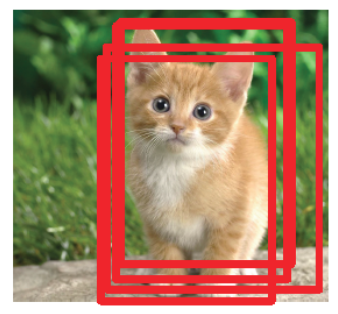
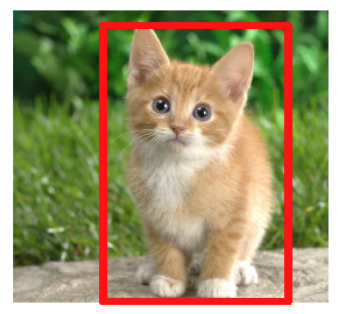

NMS的原理

1. 判断两两框之间是否重合，以及重合的IoU是多少；
2. 当IoU大于一定阈值，保留较大的分的框，删除较小的分的框。

In [12]:
import cv2
import numpy as np

def nms(bounding_boxes, confidence_score, threshold):
    if len(bounding_boxes) == 0:
        return [], []
    bboxes = np.array(bounding_boxes)
    score = np.array(confidence_score)

    # 计算 n 个候选框的面积大小
    x1 = bboxes[:, 0]
    y1 = bboxes[:, 1]
    x2 = bboxes[:, 2]
    y2 = bboxes[:, 3]
    areas =(x2 - x1 + 1) * (y2 - y1 + 1)

    # 对置信度进行排序, 获取排序后的下标序号, argsort 默认从小到大排序
    order = np.argsort(score)

    picked_boxes = [] # 返回值
    picked_score = [] # 返回值
    while order.size > 0:
        # 将当前置信度最大的框加入返回值列表中
        index = order[-1]
        picked_boxes.append(bounding_boxes[index])
        picked_score.append(confidence_score[index])

        # 获取当前置信度最大的候选框与其他任意候选框的相交面积
        x11 = np.maximum(x1[index], x1[order[:-1]])
        y11 = np.maximum(y1[index], y1[order[:-1]])
        x22 = np.minimum(x2[index], x2[order[:-1]])
        y22 = np.minimum(y2[index], y2[order[:-1]])
        w = np.maximum(0.0, x22 - x11 + 1)
        h = np.maximum(0.0, y22 - y11 + 1)
        intersection = w * h

        # 利用相交的面积和两个框自身的面积计算框的交并比, 将交并比大于阈值的框删除
        ratio = intersection / (areas[index] + areas[order[:-1]] - intersection)
        left = np.where(ratio < threshold)
        order = order[left]

    return picked_boxes, picked_score

## 总结

RCNN是真正使用深度学习进行目标检测的开山之作，为后续的faster rcnn系列提供了巨人的肩膀。

总体示意图如下图所示

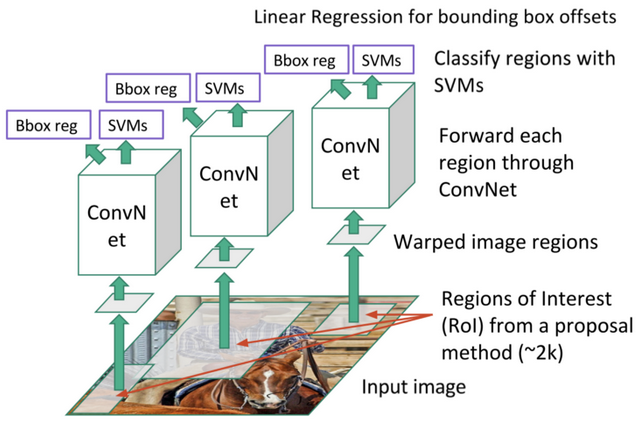

优势：

    - rcnn打破了传统思路滑动窗口的模式，提供了更加快速的检测
    - 大幅提升了传统方法的性能，在voc2007上从35\%提升到了53\%

劣势：

    - 速度依然很慢。gpu上的速度大概每张图像13秒